## MIT Shocks

- Author: Joao B. Duarte
- Last Update: 23/11/2020

- The general principle is to consider an economy that is at its steady-state in period $t$.

- Then we expose the economy to some temporary shock, under the assumption that the economy will fully have reverted back to its steady-state in period $t + T$.

- Then it’s not that hard to calculate the transition of the economy between period $t$ and $t + T$. Just compute the perfect foresight transition back to steady state!

#### Algorithm

- General principle: Guess how the capital stock will evolve from period $t + 1$ to period $t + T$ , assuming that
it’s back to it’s steady state value in $t + T + 1$. Call this guess$\{k_{t+s}^0 \}^T_{s=1}$.


- Given this guess, we can calculate wages and interest rates as $w^0_{t+s} = exp(z_{t+s})F_n(k^0_t,n)$ and
$\tilde{r}^0_{t+s} = exp(z_{t+s})F_k(k^0_t,n)$


- Using time iteration again, we can find $\tilde{g}(a, s)$ as
$$u^\prime((1+r^0_{t+s} )a+w^0_{t+s}−\tilde{g}(a,s)) = β(1 + r^0_{t+s+1}) \sum_{s^\prime} u^\prime((1 + r^0_{t+s+1} )\tilde{g}(a, s) + w^0_{t+s+1} − g^0_{t+s+1} (\tilde{g}(a, s), s′))p(s′, s)$$


- Then $g^0_{t+s}(a,s) =  max\{\tilde{g}(a,s), \phi  \}$, with $g_{t+T+1}(a,s)= g(a,s)$


- Then for each $ g^0_{t+s}$ we can find a transition matrix $M^0_{t+s}$


- Given that we know $ψ_t (a, s) = ψ(a, s)$, we can update matrix as $ψ^0_{t+s+1} = ψ^0_{t+s} × M^0_{t+s} $, and calculate the implied aggregate asset holdings $A^0_{t+s}$ 


- Finally Then we update our guess for the sequence of capital as 
$\{k^1_{t+s} \}^T_{s=1} = η\{k^0_{t+s} \}^T_{s=1} + (1 − η)\{A^0_{t+s} \}^T_{s=1}$ with $η ∈ (0, 1]$


- And repeat until $||\{k^{n+1}_{t+s}\}^T_{s=1} − \{k^n_{t+s} \}^T_{s=1}||<\epsilon$

### MIT Shock in Aiyagari Model

In [88]:
# Import Libraries
import numpy as np
import scipy.optimize as opt
from scipy.interpolate import interp1d
from quantecon.markov import DiscreteDP
import matplotlib.pyplot as plt
from time import time
from matplotlib import rc
plt.style.use({'figure.facecolor':'white'})
rc('text', usetex=True)
%config InlineBackend.figure_format = 'retina'


gamma = 2
mu = 0.1
alpha = 0.33
phi = -1.0
beta = 0.96
delta = 0.05
a_min = -3.0
a_max = 18.0
A = 1.0
L = 1.0
N = 100

P = np.array([[0.9,0.1], [0.9, 0.1]])

agrid = np.linspace(a_min,np.log(a_max-phi+1),N)
a_vals = np.exp(agrid)+phi-1

def rd(K, A = 1.0):
    return A * alpha * (L / K)**(1 - alpha) - delta

def r_to_w(r, A = 1.0):
    """
    Equilibrium wages associated with a given interest rate r.
    """
    return A * (1 - alpha) * (A * alpha / (r + delta))**(alpha / (1 - alpha))

def policy(r0, w0, r1, w1):
    ag1 = a_vals.copy()
    ab1 = a_vals.copy()
    ag = a_vals.copy()
    ab = a_vals.copy()
    metric = 1
    
    while metric > 1e-6:

        gg = interp1d(ag1, a_vals,  'linear', fill_value = 'extrapolate')
        gb = interp1d(ab1, a_vals,  'linear',  fill_value = 'extrapolate')

        Eg = beta*(1+r1)*( P[1,1]*(a_vals*(1+r1)+w1-np.maximum(gg(a_vals),phi))**(-gamma)+P[1,0]*(a_vals*(1+r1)+mu*w1-np.maximum(gb(a_vals),phi))**(-gamma) )
        Eb = beta*(1+r1)*( P[0,1]*(a_vals*(1+r1)+w1-np.maximum(gg(a_vals),phi))**(-gamma)+P[0,0]*(a_vals*(1+r1)+mu*w1-np.maximum(gb(a_vals),phi))**(-gamma) )

        ag1 = (Eg**(-1/gamma)-w0+a_vals)/(1+r0)
        ab1 = (Eb**(-1/gamma)-mu*w0+a_vals)/(1+r0)
        
        metric = np.array(([abs(ag1-ag),abs(ab1-ab)])).max()

        ag = ag1
        ab = ab1

    return gg, gb


def makeTransition_M(gg, gb):
    a1g_star, a1b_star = np.maximum(gg(a_vals),phi), np.maximum(gb(a_vals),phi)
    F = interp1d(a_vals,a_vals, kind = 'next', fill_value = a_vals[-1], bounds_error=False)
    a1gd_star = F(np.maximum(gg(a_vals),phi))
    a1bd_star = F(np.maximum(gb(a_vals),phi))

    Tg = np.zeros([N,N])
    Tb = np.zeros([N,N])

    for i in range(N):
    
        ixg = np.where(a_vals==a1gd_star[i])[0][0]
        Tg[i,ixg] = 1-(a_vals[ixg]-a1g_star[i])/(a_vals[ixg]-a_vals[ixg-1])
        if Tg[i,ixg] > 1:
            Tg[i,ixg] = 1.0
        Tg[i,ixg-1] = 1-Tg[i,ixg]
    
        ixb = np.where(a_vals==a1bd_star[i])[0][0]
        if ixb == 0:
            Tb[i,ixb] = 1.0
        else:
            Tb[i,ixb] = 1-(a_vals[ixb]-a1b_star[i])/(a_vals[ixb]-a_vals[ixb-1])
            if Tb[i,ixb] > 1:
                Tb[i,ixb] = 1.0
            Tb[i,ixb-1] = 1-Tb[i,ixb]
    M = np.concatenate((np.concatenate((P[0,0]*Tb, P[0,1]*Tb), axis=1),np.concatenate((P[1,0]*Tg,P[1,1]*Tg), axis=1)), axis=0)
    return M

def GetStationaryDist(M):
    eval,evec = np.linalg.eig(M.T)
    i = np.argmin(np.abs(eval-1.0))
    D = np.array(evec[:,i]).flatten()
    assert np.max(np.abs(np.imag(D))) < 1e-6
    D = np.real(D)  # just recasts as float
    D = D/D.sum()
    D[D<0]=0
    return D/D.sum()

def agr_capital(dist):
    a_dist = dist[:N]+dist[N:]
    return np.dot(a_vals.T, a_dist)

def prices_to_capital(r):
    gg, gb = policy(r, r_to_w(r), r, r_to_w(r))
    M = makeTransition_M(gg,gb)
    dist = GetStationaryDist(M)
    K = agr_capital(dist)
    return K

def equilibrium_ss():
    res = lambda K: K - prices_to_capital(rd(K))
    Kss_certain =  ((1/beta-1+delta)/alpha)**(1./(alpha-1))
    sol  = opt.root_scalar(res, bracket = [0.8*Kss_certain,1.2*Kss_certain], method = 'brentq').root
    return sol


def policy_back(r0, w0, r1, w1, gg, gb):

    Eg = beta*(1+r1)*( P[1,1]*(a_vals*(1+r1)+w1-np.maximum(gg(a_vals),phi))**(-gamma)+P[1,0]*(a_vals*(1+r1)+mu*w1-np.maximum(gb(a_vals),phi))**(-gamma) )
    Eb = beta*(1+r1)*( P[0,1]*(a_vals*(1+r1)+w1-np.maximum(gg(a_vals),phi))**(-gamma)+P[0,0]*(a_vals*(1+r1)+mu*w1-np.maximum(gb(a_vals),phi))**(-gamma) )

    ag1 = (Eg**(-1/gamma)-w0+a_vals)/(1+r0)
    ab1 = (Eb**(-1/gamma)-mu*w0+a_vals)/(1+r0)

    gg1 = interp1d(ag1, a_vals,  'linear', fill_value = 'extrapolate')
    gb1 = interp1d(ab1, a_vals,  'linear',  fill_value = 'extrapolate')

    return gg1, gb1

### Find Stationary Equilibrium

In [338]:
Kss = equilibrium_ss()
print(f'Equilibrium capital is {Kss}')

Equilibrium capital is 7.044756293424861


In [339]:
r = rd(Kss)
w = r_to_w(r)
gg, gb = policy(r, w, r, w)
M = makeTransition_M(gg, gb)
dist = GetStationaryDist(M)
agr_capital(dist)

7.044756293428473

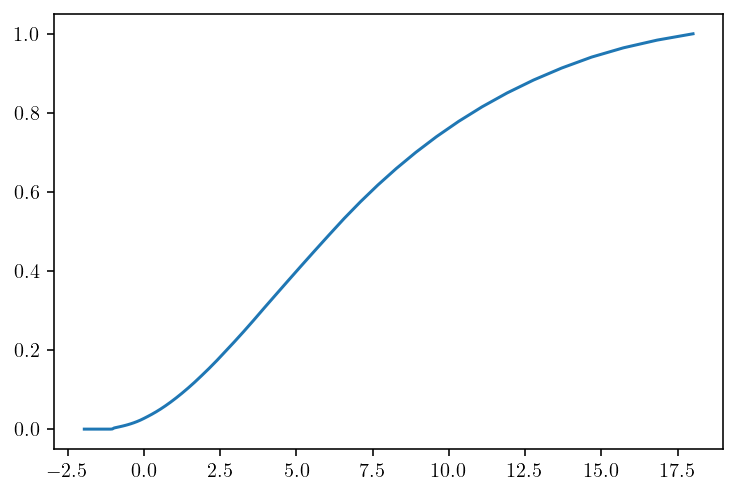

In [340]:
plt.plot(a_vals, np.cumsum(dist[:N]+dist[N:]))
plt.show()

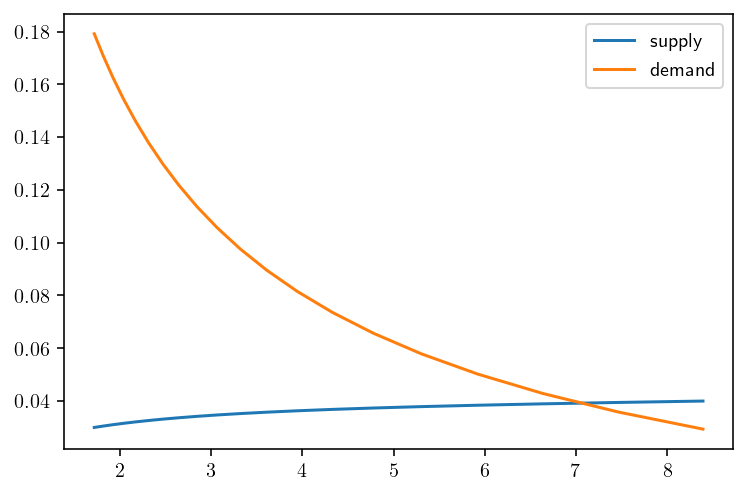

In [341]:
num_points = 20
r_vals = np.linspace(0.03, 0.04, num_points)
k_vals = np.zeros(num_points)
for i, r in enumerate(r_vals):
    k_vals[i] = prices_to_capital(r)


plt.plot(k_vals, r_vals, label='supply')
plt.plot(k_vals, rd(k_vals), label='demand')
plt.legend()
plt.show()

In [342]:
dist.shape

(200,)

### TFP MIT Shock

In [382]:
s = 70
# AR(1) process for TFP
def A1(z, rho=0.5):
    return (1-rho) + z*rho
As = [1.01]
for i in range(1,s+1):
    As.append(A1(As[i-1]))
As = np.array(As)

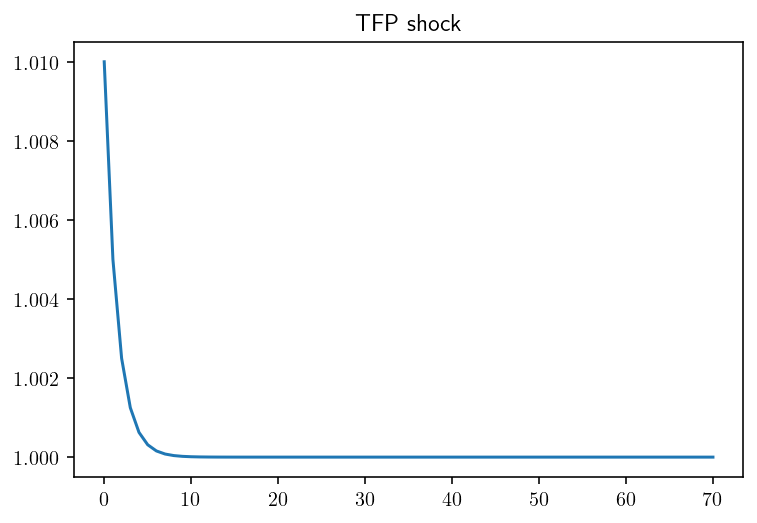

In [383]:
plt.plot(np.arange(s+1), As)
plt.title('TFP shock')
plt.show()

In [384]:
# Guess K sequence
K0s = np.ones(s+1)*Kss

gg_ss, gb_ss = policy(rd(Kss), r_to_w(rd(Kss)), rd(Kss), r_to_w(rd(Kss)))

In [385]:
# Update Prices
rs = rd(K0s, As)
    
ws = r_to_w(rs, As)

rs

array([0.04010837, 0.03966228, 0.03943924, 0.03932772, 0.03927196,
       0.03924408, 0.03923014, 0.03922317, 0.03921969, 0.03921795,
       0.03921707, 0.03921664, 0.03921642, 0.03921631, 0.03921626,
       0.03921623, 0.03921622, 0.03921621, 0.03921621, 0.03921621,
       0.0392162 , 0.0392162 , 0.0392162 , 0.0392162 , 0.0392162 ,
       0.0392162 , 0.0392162 , 0.0392162 , 0.0392162 , 0.0392162 ,
       0.0392162 , 0.0392162 , 0.0392162 , 0.0392162 , 0.0392162 ,
       0.0392162 , 0.0392162 , 0.0392162 , 0.0392162 , 0.0392162 ,
       0.0392162 , 0.0392162 , 0.0392162 , 0.0392162 , 0.0392162 ,
       0.0392162 , 0.0392162 , 0.0392162 , 0.0392162 , 0.0392162 ,
       0.0392162 , 0.0392162 , 0.0392162 , 0.0392162 , 0.0392162 ,
       0.0392162 , 0.0392162 , 0.0392162 , 0.0392162 , 0.0392162 ,
       0.0392162 , 0.0392162 , 0.0392162 , 0.0392162 , 0.0392162 ,
       0.0392162 , 0.0392162 , 0.0392162 , 0.0392162 , 0.0392162 ,
       0.0392162 ])

In [386]:
# Update Policies
ggs = [None] * s
ggs.insert(s, gg_ss)

gbs = [None] * s
gbs.insert(s, gb_ss)

for i in range(s,0,-1):
    r1 = rd(K0s[i], As[i])
    r0 = rd(K0s[i-1], As[i-1])
    w1 = r_to_w(r1, As[i])
    w0 = r_to_w(r0, As[i-1])
    gg1, gb1 = policy_back(r0, w0, r1, w1, ggs[i], gbs[i])
    ggs[i-1] = gg1
    gbs[i-1] = gb1

In [387]:
# Update Transition Matrices
Ms = [None]*s

for i in range(0,s,1):
    Ms[i]= makeTransition_M(ggs[i], gbs[i])


In [388]:
# Update Distributions
dists = [None]*s
dists[0] = dist

for i in range(1,s):
    dists[i] = np.dot(Ms[i].T,dists[i-1].reshape((200,1)))

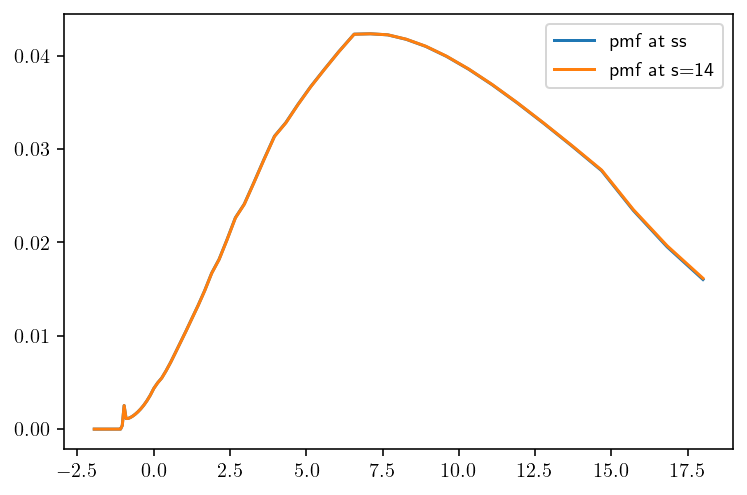

In [389]:
plt.plot(a_vals, dists[0][:N]+dists[0][N:], label='pmf at ss')
plt.plot(a_vals, dists[15][:N]+dists[15][N:], label='pmf at s=14')
plt.legend()
plt.show()

In [390]:
# Update Aggregates
K1s = [None]*s
K1s.insert(s, Kss)

for i in range(0,s-1,1):
    K1s[i] = agr_capital(dists[i+1])

In [391]:
K1s[0]

array([7.04884654])

/Users/joaoduarte/opt/anaconda3/envs/Notebooks/lib/python3.8/site-packages/numpy/core/_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)


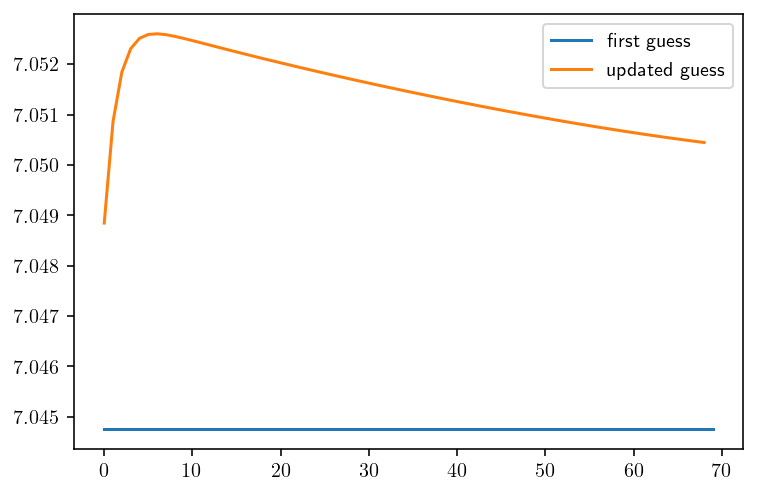

In [392]:
plt.plot(np.arange(s),K0s[:-1], label = 'first guess')
plt.plot(np.arange(s),K1s[:-1], label= 'updated guess')
plt.legend()
plt.show()

In [393]:
def update_agreggates(K0s):
    # Update Prices
    rs = rd(K0s, As)

    ws = r_to_w(rs, As)
    
    # Update Policies
    ggs = [None]*s
    ggs.insert(s, gg_ss)

    gbs = [None]*s
    gbs.insert(s, gb_ss)

    for i in range(s,0,-1):
        r1 = rd(K0s[i], As[i])
        r0 = rd(K0s[i-1], As[i-1])
        w1 = r_to_w(r1, As[i])
        w0 = r_to_w(r0, As[i-1])
        gg1, gb1 = policy_back(r0, w0, r1, w1, ggs[i], gbs[i])
        ggs[i-1] = gg1
        gbs[i-1] = gb1
        
    Ms = [None]*s

    for i in range(0,s,1):
        Ms[i]= makeTransition_M(ggs[i], gbs[i])
        
    # Update Distributions
    dists = [None]*(s+1)
    dists[0] = dist

    for i in range(1,s+1):
        dists[i] = np.dot(Ms[i-1].T,dists[i-1].reshape((200,1)))
        
    K1s = [None]*s
    K1s.insert(s, Kss)

    for i in range(0,s,1):
        K1s[i] = agr_capital(dists[i+1])[0]

    return np.array(K1s), ggs, gbs, dists

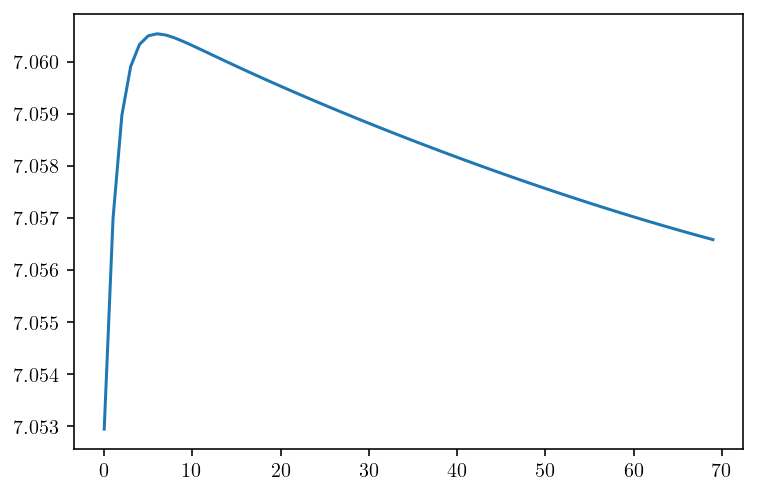

In [394]:
k1 = update_agreggates(K0s)
plt.plot(np.arange(0,s),k1[0][:-1])
plt.show()

In [395]:
np.amax(abs(k1[0]-K0s))

0.01577922246656449

In [396]:
def equilibrium_trans(Kguess):
    dif = 1
    print('Computing MIT-shock IRF...')
    while dif>1e-6:
        aggK, ggs, gbs, dists = update_agreggates(Kguess)
        dif = np.amax(abs(aggK - Kguess))
        Kguess = 0.2*aggK + 0.8*Kguess
    print('/n ...done!')
    return aggK, ggs, gbs, dists

aggK, ggs, gbs, dists = equilibrium_trans(K0s)

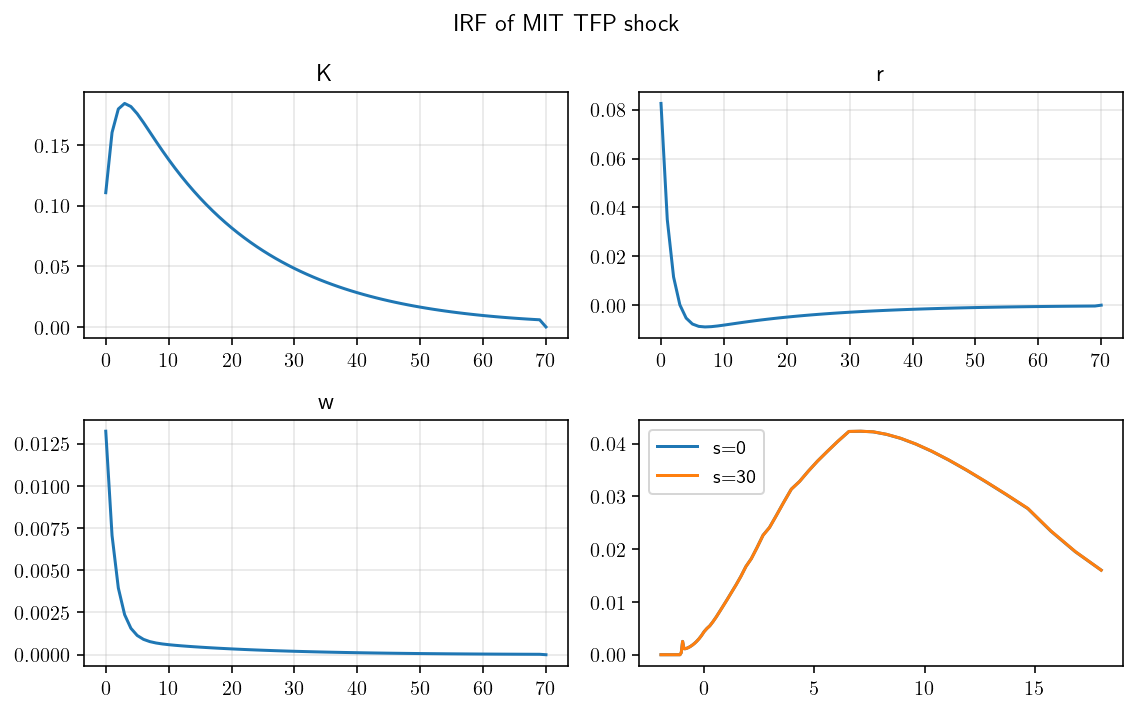

In [408]:
fig, ax = plt.subplots(2,2, figsize = (8,5))
plt.suptitle('IRF of MIT TFP shock')
ax[0,0].plot(np.arange(0,s+1), (aggK-Kss)/Kss*100)
ax[0,0].set_title('K')
ax[0,0].grid(alpha=0.3)
ax[0,1].plot(np.arange(0,s+1), (rd(aggK, As)-rd(Kss))*100)
ax[0,1].set_title('r')
ax[0,1].grid(alpha=0.3)
ax[1,0].plot(np.arange(0,s+1), (r_to_w(rd(aggK, As), As)-r_to_w(rd(Kss))))
ax[1,0].set_title('w')
ax[1,0].grid(alpha=0.3)
ax[1,1].plot(a_vals, dists[0][:N]+dists[0][N:], label = 's=0')
ax[1,1].plot(a_vals, dists[30][:N]+dists[30][N:], label = 's=30')
ax[1,1].legend()

plt.tight_layout()
plt.show()